<a href="https://colab.research.google.com/github/roxyrong/emotion_detection/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import librosa
import librosa.display
import math
import random
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
#from google.colab import auth
#from google.cloud import storage
#auth.authenticate_user()
#client = storage.Client()

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_dir = '/content/drive/MyDrive/W207 project/Final Project - Video Process/Process_3_Matrix_Conversion/cnnlstm_dataset_crop.npy'
image_arr = np.load(image_dir, allow_pickle=True)

In [ ]:
image_df = pd.DataFrame(image_arr, columns=['image', 'label', 'speaker', 'hotcode'])
new_df = image_df.explode('image').reset_index(drop=True)
new_df.head(2)

,image,label,speaker,hotcode
0,"[[[4, 8, 9], [3, 7, 8], [3, 8, 7], [4, 9, 8], ...",a,DC,0
1,"[[[6, 8, 9], [6, 8, 8], [4, 9, 7], [4, 10, 5],...",a,DC,0


In [ ]:
new_df.image[0].shape

(64, 64, 3)

In [ ]:
# shufflt the dataset
image_df = new_df.sample(frac=1).reset_index(drop=True)
image_df.head(10)

,image,label,speaker,hotcode
0,"[[[0, 6, 3], [0, 6, 3], [2, 4, 4], [5, 5, 5], ...",f,JK,6
1,"[[[0, 4, 5], [1, 5, 6], [1, 6, 5], [1, 6, 5], ...",h,KL,5
2,"[[[4, 10, 9], [5, 10, 9], [7, 9, 10], [9, 9, 9...",sa,DC,3
3,"[[[1, 7, 2], [1, 7, 2], [4, 6, 6], [3, 8, 7], ...",a,JK,0
4,"[[[2, 4, 5], [2, 4, 5], [0, 5, 4], [1, 6, 5], ...",n,KL,1
5,"[[[4, 9, 10], [4, 9, 10], [5, 10, 9], [5, 10, ...",d,DC,4
6,"[[[0, 3, 7], [0, 4, 5], [0, 5, 4], [0, 5, 3], ...",d,JK,4
7,"[[[0, 5, 4], [0, 6, 5], [1, 5, 6], [3, 5, 5], ...",h,JK,5
8,"[[[0, 5, 4], [0, 5, 4], [1, 5, 6], [1, 5, 6], ...",sa,KL,3
9,"[[[0, 6, 5], [1, 7, 6], [5, 7, 8], [5, 7, 7], ...",h,JK,5


In [ ]:
images = np.array(image_df['image'].tolist())
labels = np.array(image_df['hotcode'].tolist())

train_images, train_labels = images[:320*6], labels[:320*6]
valid_images, valid_labels = images[320*6:400*6], labels[320*6:400*6]
test_images, test_labels = images[400*6:], labels[400*6:]

# Define base VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create data generators and normalize it
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
valid_generator = valid_datagen.flow(valid_images, valid_labels, batch_size=32)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32, shuffle=False)

# Train the model
history = model.fit(train_generator,steps_per_epoch=len(train_generator), epochs=50, validation_data=valid_generator)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

Epoch 1/50
60/60 [==============================] - 53s 872ms/step - loss: 1.9178 - accuracy: 0.2453 - val_loss: 1.7243 - val_accuracy: 0.3313
Epoch 2/50
60/60 [==============================] - 52s 862ms/step - loss: 1.7574 - accuracy: 0.3130 - val_loss: 1.6236 - val_accuracy: 0.3167
Epoch 3/50
60/60 [==============================] - 51s 860ms/step - loss: 1.6802 - accuracy: 0.3484 - val_loss: 1.5440 - val_accuracy: 0.4437
Epoch 4/50
60/60 [==============================] - 51s 849ms/step - loss: 1.6301 - accuracy: 0.3802 - val_loss: 1.5384 - val_accuracy: 0.4187
Epoch 5/50
60/60 [==============================] - 52s 865ms/step - loss: 1.5339 - accuracy: 0.4281 - val_loss: 1.5164 - val_accuracy: 0.3792
Epoch 6/50
60/60 [==============================] - 52s 866ms/step - loss: 1.5241 - accuracy: 0.4182 - val_loss: 1.4406 - val_accuracy: 0.4167
Epoch 7/50
60/60 [==============================] - 52s 866ms/step - loss: 1.4962 - accuracy: 0.4344 - val_loss: 1.4235 - val_accuracy: 0.4292

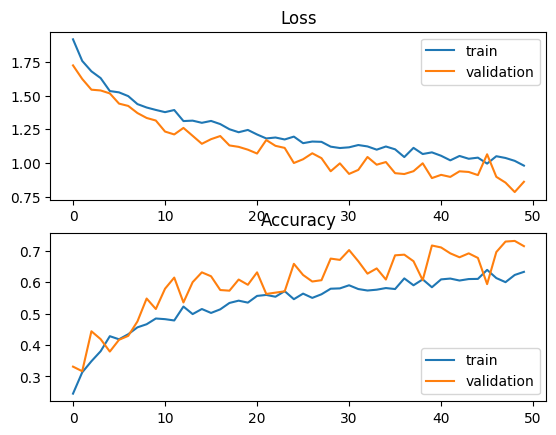

In [ ]:
from matplotlib import pyplot
 
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='validation')
pyplot.legend()
pyplot.show()

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(test_datagen.flow(test_images, test_labels, batch_size=32, shuffle=False), steps=len(test_generator), verbose=0)
# predict crisp classes for test set
classes_x=np.argmax(yhat_probs,axis=1)

[Text(0, 0.5, 'Anger'),
 Text(0, 1.5, 'Neutral'),
 Text(0, 2.5, 'Surprise'),
 Text(0, 3.5, 'Sad'),
 Text(0, 4.5, 'Disgust'),
 Text(0, 5.5, 'Happy'),
 Text(0, 6.5, 'Fear')]

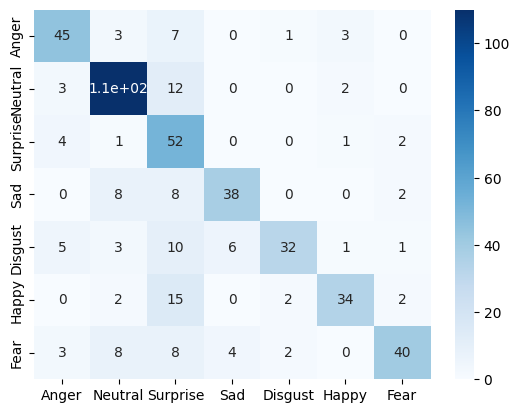

In [ ]:
ax= plt.subplot()
cm = confusion_matrix(test_labels, classes_x,)
sns.heatmap(cm, annot=True, cmap='Blues', ax= ax)
ax.xaxis.set_ticklabels(['Anger', 'Neutral','Surprise','Sad', 'Disgust', 'Happy', 'Fear'])
ax.yaxis.set_ticklabels(['Anger', 'Neutral','Surprise','Sad', 'Disgust', 'Happy', 'Fear'])

In [ ]:
accuracy = accuracy_score(test_labels, classes_x)
print('Accuracy: %f' % accuracy)
precision = precision_score(test_labels, classes_x,average='weighted')
print('Precision: %f' % precision)
recall = recall_score(test_labels, classes_x,average='weighted')
print('Recall: %f' % recall)
f1 = f1_score(test_labels, classes_x,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.731250
Precision: 0.772944
Recall: 0.731250
F1 score: 0.735262


In [ ]:
model.save('/content/drive/MyDrive/W207-Spring-2023/W207 project/TransferLearningModels/vgg16_transfer_model_50epo.h5')

#Audio Model

In [ ]:
#bucket = client.get_bucket('savee')
#blob = bucket.blob('raw_audio_features_extraction_0324.csv')
#blob.download_to_filename('raw_audio_features_extraction_0324.csv')
audio_dir = '/content/drive/MyDrive/W207 project/data/raw_audio_features_extraction_0324.npy'
audio_arr = np.load(audio_dir, allow_pickle=True)

In [ ]:
audio_csv_dir = '/content/drive/MyDrive/W207 project/data/raw_audio_features_extraction_0324.csv'
headers = pd.read_csv(audio_csv_dir , index_col=0, nrows=0).columns.tolist()

In [ ]:
audio_df = pd.DataFrame(audio_arr, columns=['data']+headers)
audio_df = audio_df[['data', 'path', 'speaker', 'augmented', 'mfcc']]
audio_df['label'] = [x.split('/')[2][:-6] for x in audio_df.path]
audio_df['emo_label'] = pd.factorize(audio_df['label'])[0]
audio_df['fold'] = pd.factorize(audio_df['speaker'])[0]
audio_df.head(2)

,data,path,speaker,augmented,mfcc,label,emo_label,fold
0,"[0.035011273, 0.052110124, 0.0455472, 0.049692...",AudioData/DC/a01.wav,DC,False,"[[-219.52531, -193.17221, -200.38965, -219.389...",a,0,0
1,"[0.028584875, 0.043024283, 0.038623992, 0.0423...",AudioData/DC/a02.wav,DC,False,"[[-267.86603, -136.18143, -103.85412, -143.051...",a,0,0


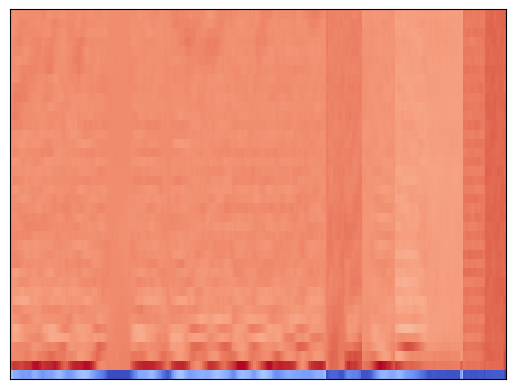

In [ ]:
audio_csv_dir = '/content/drive/MyDrive/W207 project/data/image/'
ind = 0
for img in audio_df.mfcc:
  librosa.display.specshow(img)
  plt.savefig(audio_csv_dir + str(ind) + '.png')
  ind += 1

In [ ]:
import glob
files = glob.glob('/content/drive/MyDrive/W207 project/data/image/*.*')
data = []
index_order = []
for i in files:   
    ind = int(str(i).split('/')[-1].split('.')[0])
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
    image=np.array(image)
    data.append(image)
    index_order.append(ind)

data = [data[i] for i in index_order]

In [ ]:
#deal with dataset imbalance
data_neu = audio_df[audio_df.emo_label==4]
data_oth = audio_df[audio_df.emo_label!=4]
data_new_resize = data_neu.sample(frac=0.5)
index_list = list(data_oth.index) + list(data_new_resize.index)
data_final = [data[i] for i in index_list]
label_final = [audio_df.emo_label[i] for i in index_list]

In [ ]:
from keras.applications import VGG19
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = np.array(data_final)
y = pd.Series(label_final)

# Split data into train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio/(train_ratio+val_ratio), random_state=1)
X_train = X_train.astype('float32')/255.0
X_val = X_val.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

# Load VGG19
vgg = VGG19(include_top=False, input_shape=(224, 224,3), weights='imagenet')
for layer in vgg.layers:
    layer.trainable = False

# build model
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

# Compile
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train and save the best epoch
STAMP = 'simple_transfer_vgg19'
early_stopping =EarlyStopping(monitor='val_loss', patience=10)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50, 
                    callbacks=[early_stopping, model_checkpoint])
model.load_weights(bst_model_path)
# evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/50
37/37 [==============================] - 536s 14s/step - loss: 3.2988 - accuracy: 0.1838 - val_loss: 1.9126 - val_accuracy: 0.1937
Epoch 2/50
37/37 [==============================] - 532s 14s/step - loss: 1.9572 - accuracy: 0.1974 - val_loss: 1.8930 - val_accuracy: 0.2095
Epoch 3/50
37/37 [==============================] - 528s 14s/step - loss: 1.9003 - accuracy: 0.2017 - val_loss: 1.8516 - val_accuracy: 0.2767
Epoch 4/50
37/37 [==============================] - 526s 14s/step - loss: 1.8508 - accuracy: 0.2332 - val_loss: 1.8030 - val_accuracy: 0.2530
Epoch 5/50
37/37 [==============================] - 577s 16s/step - loss: 1.8297 - accuracy: 0.2366 - val_loss: 1.7241 - val_accuracy: 0.3083
Epoch 6/50
37/37 [==============================] - 520s 14s/step - loss: 1.8143 - accuracy: 0.1991 - val_loss: 1.8121 - val_accuracy: 0.2411
Epoch 7/50
37/37 [==============================] - 522s 14s/step - loss: 1.7453 - accuracy: 0.2562 - val_loss: 1.7010 - val_accuracy: 0.2727
Epoch 

NameError: ignored

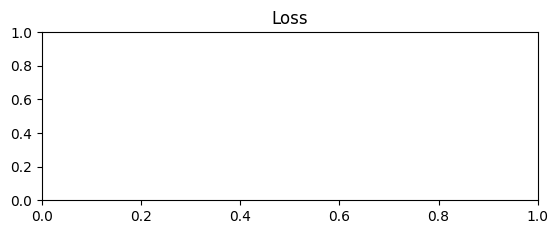

In [ ]:
from matplotlib import pyplot
 
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='validation')
pyplot.legend()
pyplot.show()

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(X_test)
# predict crisp classes for test set
classes_x=np.argmax(yhat_probs,axis=1)

ax= plt.subplot()
cm = confusion_matrix(y_test, classes_x,)
sns.heatmap(cm, annot=True, cmap='Blues', ax= ax)
ax.xaxis.set_ticklabels(['Anger', 'Neutral','Surprise','Sad', 'Disgust', 'Happy', 'Fear'])
ax.yaxis.set_ticklabels(['Anger', 'Neutral','Surprise','Sad', 'Disgust', 'Happy', 'Fear'])

In [ ]:
accuracy = accuracy_score(y_test, classes_x)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, classes_x,average='weighted')
print('Precision: %f' % precision)
recall = recall_score(y_test, classes_x,average='weighted')
print('Recall: %f' % recall)
f1 = f1_score(y_test, classes_x,average='weighted')
print('F1 score: %f' % f1)

## YAMNet  

Code heavily referenced from: https://www.tensorflow.org/tutorials/audio/transfer_learning_audio 

In [ ]:
data_neu = audio_df[audio_df.emo_label==4]
data_oth = audio_df[audio_df.emo_label!=4]
data_new_resize = data_neu.sample(frac=0.5)
index_list = list(data_oth.index) + list(data_new_resize.index)

In [ ]:
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers import Input, Dense, Dropout
from keras.models import Model
#import tensorflow_io as tfio

# Load YAMNet model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
audio_yam_df = audio_df[audio_df.index.isin(index_list)]

In [ ]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])
scores, embeddings, spectrogram = yamnet_model(audio_yam_df.data[0])
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Speech
The embeddings shape: (10, 1024)


In [ ]:
max_len = 157409  # Maximum length of audio files 
padded_y = []
for audio_data in audio_df.data:
    max_samples = 157409
    y_padded = librosa.util.fix_length(audio_data, size=max_samples)
    y_padded = tf.convert_to_tensor(y_padded.astype('float32'))
    padded_y.append(y_padded)
audio_df['padded_data'] = padded_y

num_folds = 5
audio_df = audio_df.sample(frac=1).reset_index(drop=True)
audio_df = audio_df.sample(frac=1).reset_index(drop=True)
audio_df = audio_df.sample(frac=1).reset_index(drop=True)
samples_per_fold = len(audio_df) // num_folds

audio_df['fold'] = 0
for i in range(num_folds):
    start_index = i * samples_per_fold
    end_index = start_index + samples_per_fold
    audio_df.loc[start_index:end_index, 'fold'] = i

def extract_embedding(wav_data, label, fold):
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

files = audio_df['padded_data']
targets = audio_df['emo_label']
folds = audio_df['fold'].astype('float32')

main_ds = tf.data.Dataset.from_tensor_slices((padded_y, targets, folds))
main_ds.element_spec
# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
print(main_ds.element_spec)

# Split the data into train, validation, and test sets
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 3)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 3)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

# Build the classifier
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dropout(0.5),            
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
], name='my_model')

# Compile the classifier
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,restore_best_weights=True)

# Train the classifier
history = model.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds,
                    callbacks=callback)




(TensorSpec(shape=(1024,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))
Epoch 1/20
720/720 [==============================] - 199s 268ms/step - loss: 1.9670 - accuracy: 0.2481 - val_loss: 1.9829 - val_accuracy: 0.2438
Epoch 2/20
720/720 [==============================] - 5s 7ms/step - loss: 1.8860 - accuracy: 0.2622 - val_loss: 1.9744 - val_accuracy: 0.2448
Epoch 3/20
720/720 [==============================] - 5s 7ms/step - loss: 1.8819 - accuracy: 0.2608 - val_loss: 1.9542 - val_accuracy: 0.2448
Epoch 4/20
720/720 [==============================] - 5s 7ms/step - loss: 1.8804 - accuracy: 0.2624 - val_loss: 1.9702 - val_accuracy: 0.2449
Epoch 5/20
720/720 [==============================] - 5s 7ms/step - loss: 1.8752 - accuracy: 0.2628 - val_loss: 1.9621 - val_accuracy: 0.2432
Epoch 6/20
720/720 [==============================] - 5s 7ms/step - loss: 1.8735 - accuracy: 0.2611 - val_loss: 1.9828 - val_accu

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

240/240 [==============================] - 3s 3ms/step - loss: 1.9961 - accuracy: 0.2103
Loss:  1.9960994720458984
Accuracy:  0.2102864533662796


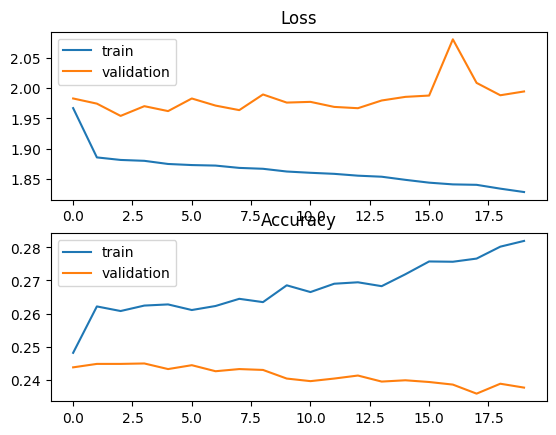

In [ ]:
from matplotlib import pyplot
 
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='validation')
pyplot.legend()
pyplot.show()

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 21ms/step


[Text(0, 0.5, 'Anger'),
 Text(0, 1.5, 'Neutral'),
 Text(0, 2.5, 'Surprise'),
 Text(0, 3.5, 'Sad'),
 Text(0, 4.5, 'Disgust'),
 Text(0, 5.5, 'Happy'),
 Text(0, 6.5, 'Fear')]

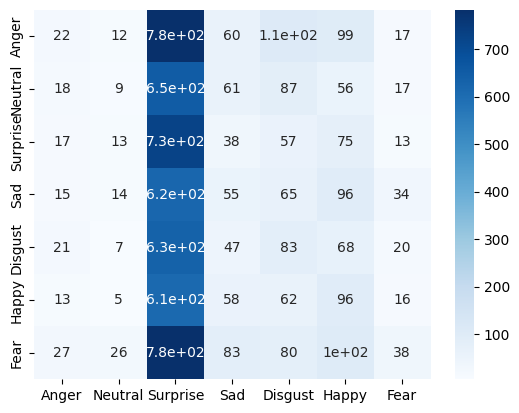

In [ ]:
ax= plt.subplot()
cm = confusion_matrix(y_test, classes_x)
sns.heatmap(cm, annot=True, cmap='Blues', ax= ax)
ax.xaxis.set_ticklabels(['Anger', 'Neutral','Surprise','Sad', 'Disgust', 'Happy', 'Fear'])
ax.yaxis.set_ticklabels(['Anger', 'Neutral','Surprise','Sad', 'Disgust', 'Happy', 'Fear'])

In [ ]:
y_test = correct_labels 
classes_x = predicted_labels
accuracy = accuracy_score(y_test, classes_x)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, classes_x,average='weighted')
print('Precision: %f' % precision)
recall = recall_score(y_test, classes_x,average='weighted')
print('Recall: %f' % recall)
f1 = f1_score(y_test, classes_x,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.210286
Precision: 0.108846
Recall: 0.210286
F1 score: 0.091301
